In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import __kalman_smooth__
import copy
import pynumdiff

import figurefirst as fifi
import os

import pickle

import scipy.stats
import scipy.ndimage

import pandas

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
def get_filenames(path, contains, does_not_contain=['~', '.pyc']):
    cmd = 'ls ' + '"' + path + '"'
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                filelist.append( os.path.join(path, filename) )
    return filelist

# Load data

In [3]:
data_directory = 'FLIVVER_DATA/figures_3_and_4'

In [4]:
results_directory = '../../Figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squarebeforeavg'

In [5]:
alphadot_meta = pandas.read_hdf(os.path.join(data_directory, 'alphadot_meta.hdf'))

In [6]:
alphas_x = alphadot_meta.xs('alphas_x')
alphas_y = alphadot_meta.xs('alphas_y')
alphas_epi = alphadot_meta.xs('alphas_epi')

In [7]:
vel_accel_time = pandas.read_hdf(os.path.join(data_directory, 'vel_accel_time.hdf'))

In [8]:
dt = vel_accel_time.xs('dt').values[0,0]
scaling = vel_accel_time.xs('scaling').values[0,0]
t = vel_accel_time.xs('time').values[:,0]

a_smooth = vel_accel_time.xs('accel_smooth_2').values[:,0]
v_true = vel_accel_time.xs('velocity_true').values[:,0]

In [9]:
v_true_smooth, a_true_smooth = pynumdiff.total_variation_regularization.jerk(v_true, dt, [100])

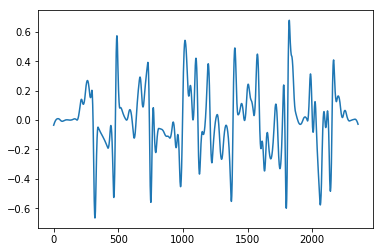

In [10]:
plt.plot(a_true_smooth)

# Load results

In [11]:
results_filenames =  get_filenames(results_directory, 'fromalphadot_nomatch')

In [12]:
def get_v_est_for_window_size(results_filenames, window_size):
    v_ests = []
    for filename in results_filenames:
        f = open(filename, 'rb')
        results = pickle.load(f)
        f.close()
        
        if results['width'] == window_size:
            if np.std(results['v_est']) > 0.5:
                v_ests.append(results['v_est'])
    return np.median(v_ests, axis=0)

In [13]:
# get true
f = open(results_filenames[0], 'rb')
results = pickle.load(f)
f.close()
v_true = results['v_true']

# Test out for one window

## Raw

In [14]:
window_size = 40
v_est = get_v_est_for_window_size(results_filenames, window_size)

(-1, 1)

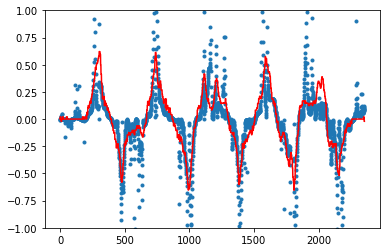

In [15]:
plt.plot(v_est, '.')
plt.plot(v_true, color='red')

plt.ylim(-1,1)

# Automate it to get RMSE for a given window

In [16]:
def get_rmse_for_window(results_directory, window, tvgamma=1, N_windows='all'):
    print(results_directory)
    results_filenames =  get_filenames(results_directory, 'fromalphadot_nomatch_' + str(window))
    print(len(results_filenames))
    
    if N_windows == 'all':
        v_est = get_v_est_for_window_size(results_filenames, window)
    else:
        idx = np.random.choice(np.arange(0, len(results_filenames)), N_windows, replace=False)
        print(len(idx))
        v_est = get_v_est_for_window_size( [results_filenames[i] for i in idx], window)
    if v_est is not None:
        params, val = pynumdiff.optimize.smooth_finite_difference.butterdiff(v_est, dt, tvgamma=tvgamma)
        print(params)
        v_est_optic_flow_butter, _ = pynumdiff.smooth_finite_difference.butterdiff(v_est, dt, params)
        rmse = np.sqrt( np.median( (np.ravel(v_est_optic_flow_butter) - v_true)**2 ))
        return rmse
    else:
        return None

In [17]:
windows = [0.078125, 0.3125, 2.5, 5, 10, 15, 20, 25, 30, 35]

In [18]:
def get_rmses_for_window_repeated_noisy(N_windows, repeats=10):
    directory = '../../Figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg'
    repeated_rmses = []
    for repeat in range(repeats):
        rmses = []
        for window in windows:
            rmse = get_rmse_for_window(directory, window, tvgamma=1, N_windows=N_windows)
            rmses.append(rmse)
        repeated_rmses.append(rmses)
    return np.mean(repeated_rmses, axis=0)

noisy_rmses_all = get_rmses_for_window_repeated_noisy('all', repeats=10)

../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

[2, 0.08114257812500006]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[2, 0.08166015625000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.06858398437500007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.06574218750000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.06861328125000006]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[1, 0.06339263343811027]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[1, 0.05710937500000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.05757812500000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.058945312500000076]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareaft

[1, 0.05710937500000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.05757812500000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.058945312500000076]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.059843750000000084]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.08114257812500006]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.08166015625000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.06858398437500007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareafteravg
49
[2, 0.06574218750000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_noisy_squareaf

In [19]:
def get_rmses_for_window_repeated_nonoise(N_windows, repeats=10):
    directory = '../../Figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg'
    repeated_rmses = []
    for repeat in range(repeats):
        rmses = []
        for window in windows:
            rmse = get_rmse_for_window(directory, window, tvgamma=1, N_windows=N_windows)
            rmses.append(rmse)
        repeated_rmses.append(rmses)
    return np.mean(repeated_rmses, axis=0)

nonoise_rmses_all = get_rmses_for_window_repeated_nonoise('all', repeats=10)

../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

[2, 0.06140625000000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[2, 0.06324218750000007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.0647167968750001]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.06564453125000011]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.06667968750000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[1, 0.06164062500000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[1, 0.05723242187499994]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.05789062500000007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.05734375000000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_non

[1, 0.05723242187499994]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.05789062500000007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.05734375000000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.05515625000000009]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.06140625000000008]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.06324218750000007]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.0647167968750001]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_nonoise_squareafteravg
49
[2, 0.06564453125000011]
../../2021_velocity_estimation_figure_4/noglobalalphadotavg_vel_ests_for_rfs_non

In [25]:
def plot_on_ax(axname, show=['left', 'bottom']):

    layout = fifi.svg_to_axes.FigureLayout('../velocity_estimats_rmse_resolution.svg', autogenlayers=True, make_mplfigures=True, hide_layers=[])
    ax = layout.axes[(axname, axname)]

    ax.plot(windows, noisy_rmses_all, '--', color='green')
    ax.plot(windows, nonoise_rmses_all, '--', color='orange')

    ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_ylim(0.06, 0.14)
    ax.set_xlim(10**-2, 10**2)
    
    if 'bottom' in show:
        fifi.mpl_functions.adjust_spines(ax, show, xticks=[10**-2, 10**-1, 10**0, 10**1, 10**2],
                                                                 yticks=[0.06, 0.08, 0.1, 0.12, 0.14])
    else:
        fifi.mpl_functions.adjust_spines(ax, show, yticks=[0.06, 0.08, 0.1, 0.12, 0.14])
    ax.set_ylim(0.06, 0.14)
    ax.set_xlim(10**-2, 10**2)

    if 'bottom' in show:
        ax.tick_params(which='minor', direction='in')
    else:
        ax.set_xticks([], minor=True)

    fifi.mpl_functions.set_fontsize(ax, 6)

    layout.append_figure_to_layer(layout.figures[axname], axname, cleartarget=True)
    layout.write_svg('../velocity_estimats_rmse_resolution.svg')

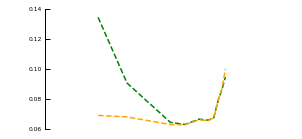

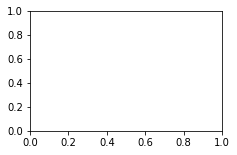

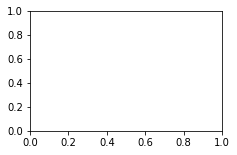

In [26]:
plot_on_ax('rmse_p1', show=['left'])

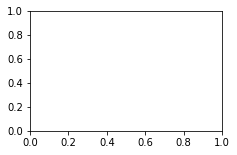

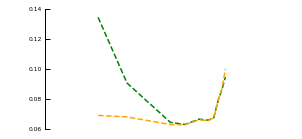

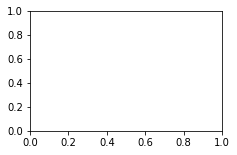

In [27]:
plot_on_ax('rmse_1', show=['left'])

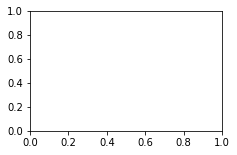

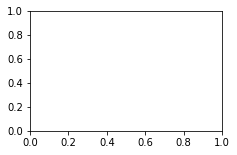

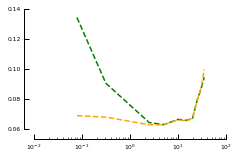

In [28]:
plot_on_ax('rmse_2')

In [20]:
def plot_on_ax(axname, show=['left', 'bottom']):

    layout = fifi.svg_to_axes.FigureLayout('../velocity_estimats_rmse.svg', autogenlayers=True, make_mplfigures=True, hide_layers=[])
    ax = layout.axes[(axname, axname)]

    ax.plot(windows, noisy_rmses_all, '--', color='green')
    ax.plot(windows, nonoise_rmses_all, '--', color='orange')

    ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.set_ylim(0.06, 0.14)
    ax.set_xlim(10**-2, 10**2)
    
    if 'bottom' in show:
        fifi.mpl_functions.adjust_spines(ax, show, xticks=[10**-2, 10**-1, 10**0, 10**1, 10**2],
                                                                 yticks=[0.06, 0.08, 0.1, 0.12, 0.14])
    else:
        fifi.mpl_functions.adjust_spines(ax, show, yticks=[0.06, 0.08, 0.1, 0.12, 0.14])
    ax.set_ylim(0.06, 0.14)
    ax.set_xlim(10**-2, 10**2)

    if 'bottom' in show:
        ax.tick_params(which='minor', direction='in')
    else:
        ax.set_xticks([], minor=True)

    fifi.mpl_functions.set_fontsize(ax, 6)

    layout.append_figure_to_layer(layout.figures[axname], axname, cleartarget=True)
    layout.write_svg('../velocity_estimats_rmse.svg')

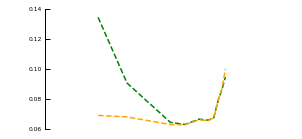

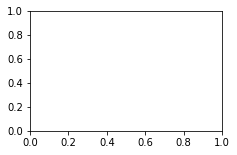

In [21]:
plot_on_ax('rmse_1', show=['left'])